### Introduction
#### In this notebook, we will build and train an artificial neural network (ANN) to classify images from the Fashion MNIST dataset. Fashion MNIST contains 28x28 grayscale images of 10 different categories of clothing items. The goal is to demonstrate how to preprocess the data, construct a neural network using **Pytorch**, train the model, and evaluate its performance on this challenging image classification task.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [7]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
base_url = "https://raw.githubusercontent.com/pranta-iitp/repos-1/master/"
file_names = [f"fashion_mnist_dataset_part_{i}.csv" for i in range(1, 8)]
urls = [base_url + name for name in file_names]

# Read and concatenate files
dfs = [pd.read_csv(url) for url in urls]
df = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(df)} samples")
print(df.head())


Loaded 70000 samples
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0        

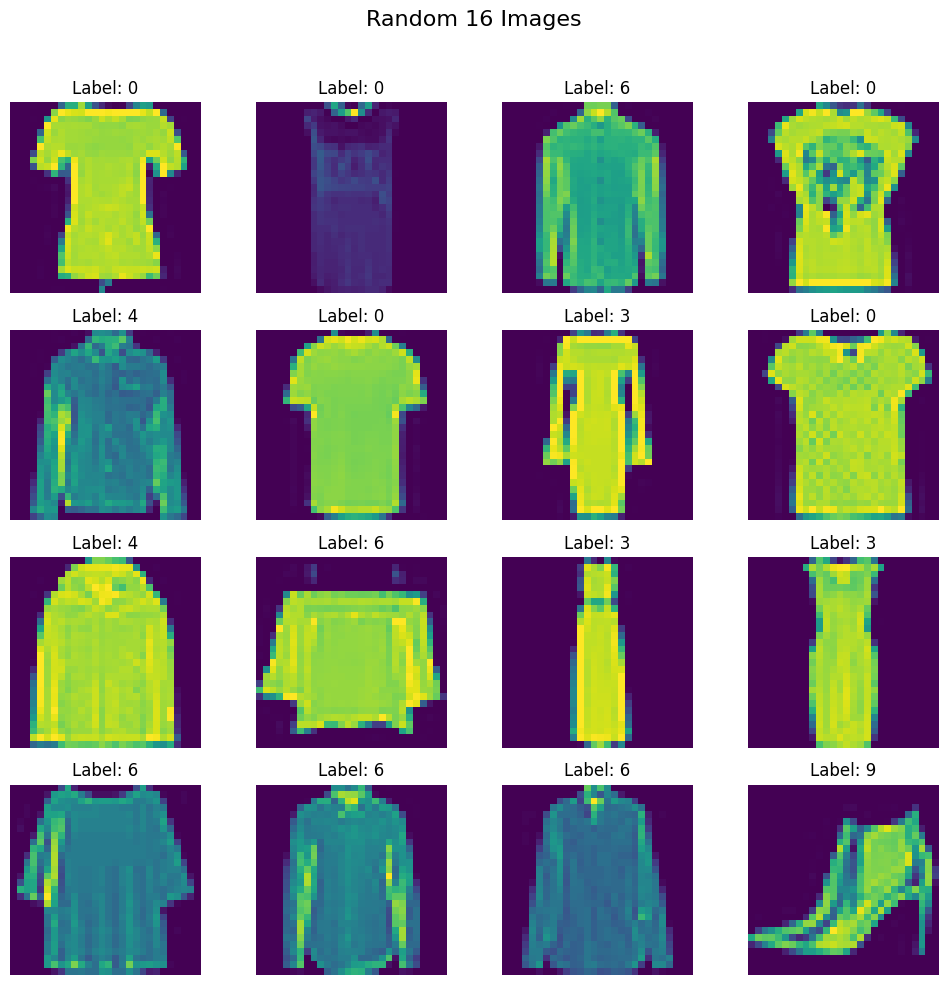

In [9]:
# Randomly select 16 unique indices from the dataframe
random_indices = np.random.choice(df.index, 16, replace=False)

# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Random 16 Images", fontsize=16)

# Plot the 16 random images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[random_indices[i], 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[random_indices[i], 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [10]:
X = df.drop(columns = ['label'])
y = df['label']

In [11]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,37,...,32,23,14,20,0,0,1,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
69998,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
y

,label
0,2
1,9
2,6
3,0
4,3
...,...
69995,0
69996,6
69997,8
69998,8


In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(f'Number of rows in trainig data set: {len(X_train)}')
print(f'Number of rows in test data set: {len(X_test)}')

Number of rows in trainig data set: 56000
Number of rows in test data set: 14000


### Scaling
#### Scale the pixel values of the images from their original range of 0 to 255 down to a range of 0 to 1. This normalization step helps neural networks train more efficiently and achieve better performance

In [15]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

### Dataset Class
#### The Dataset class in PyTorch is an abstract class that represents a dataset. It is designed to store data samples and their corresponding labels and to provide a way to access individual samples

In [16]:
# create Custom Dataset Class
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features.values, dtype=torch.float32)
    self.labels = torch.tensor(labels.values, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [17]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [18]:
# create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

### DataLoader Class
* The DataLoader class wraps an iterable around a Dataset and provides an efficient way to access data in batches, shuffle data, and load data in parallel using multiple workers.

* It is responsible for batching the data, optionally shuffling it at each epoch, and loading it efficiently during training and testing.

In [19]:
# define CustomNNModel class
class CustomNNModel(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [20]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = CustomNNModel(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total
  return accuracy

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.1 MB/s eta 0:00:00


In [21]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-06-20 18:28:32,663] A new study created in memory with name: no-name-9a4228de-9385-427b-af81-f527d8df7845


In [22]:
study.optimize(objective, n_trials=10)

[I 2025-06-20 18:29:30,037] Trial 0 finished with value: 0.8514285714285714 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 16, 'epochs': 20, 'learning_rate': 0.0383358061183709, 'dropout_rate': 0.1, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 2.4221408991473186e-05}. Best is trial 0 with value: 0.8514285714285714.
[I 2025-06-20 18:32:02,395] Trial 1 finished with value: 0.8834285714285715 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 64, 'epochs': 40, 'learning_rate': 8.610690105387987e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.0009463128337097402}. Best is trial 1 with value: 0.8834285714285715.
[I 2025-06-20 18:36:33,411] Trial 2 finished with value: 0.8792857142857143 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 30, 'learning_rate': 0.00021108804580912392, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.0003322802507382124

In [23]:
study.best_value

0.8834285714285715

In [24]:
study.best_params

{'num_hidden_layers': 3,
 'neurons_per_layer': 64,
 'epochs': 40,
 'learning_rate': 8.610690105387987e-05,
 'dropout_rate': 0.30000000000000004,
 'batch_size': 64,
 'optimizer': 'Adam',
 'weight_decay': 0.0009463128337097402}